# EECS 595 HW3: Parts 1-3 Building and Pre-Training BERT from Scratch

In [265]:
import os
import math
import numpy as np
import random
import logging

# Bring in PyTorch
import torch
import torch.nn as nn
# optimizer transfo

# Most of the examples have typing on the signatures for readability
from typing import Optional, Callable, List, Tuple
from copy import deepcopy
# For data loading
from torch.utils.data import Dataset, IterableDataset, TensorDataset, DataLoader
import json
import glob
import gzip
import bz2
import wandb

import matplotlib.pyplot as plt

# For progress and timing
from tqdm.auto import tqdm, trange
import time

# Part 1: Tokenization

To start with, we'll load in one of the tokenizers for the original BERT from the `tokenizers` package. 

In [266]:
################################################################
#                     TODO: YOUR CODE HERE                     #
#
#  1. Create a new BertWordPieceTokenizer using the specified vocab.txt file in the homework. 
#     Make sure that all tokens are lowed cased.
#
################################################################
from tokenizers import BertWordPieceTokenizer

tokenizer = BertWordPieceTokenizer("vocab.txt", lowercase=True)

# Test the tokenizer
print(tokenizer.encode("Hello, I am learning to tokenize").tokens)

['[CLS]', 'hello', ',', 'i', 'am', 'learning', 'to', 'token', '##ize', '[SEP]']


In [267]:
sentence1 = "This is my first test sentence's words. I am programming. Unconditionally, comfortable; professional. nongrammatical sentence... "

print(tokenizer.encode(sentence1).tokens)



['[CLS]', 'this', 'is', 'my', 'first', 'test', 'sentence', "'", 's', 'words', '.', 'i', 'am', 'programming', '.', 'un', '##con', '##ditional', '##ly', ',', 'comfortable', ';', 'professional', '.', 'non', '##gram', '##matic', '##al', 'sentence', '.', '.', '.', '[SEP]']


# Part 2: Building a Transformer Encoder and BERT

The BERT model is a pre-trained transformer network. Creating a small BERT model will take two big piecse (1) building the transformer itself and (2) writing the code that incorporates the tranformer into BERT and has it set up for training. We'll try to simplify building this by thinking of the different pieces as building blocks that we can put together. Remember, all neural networks are _functions_ and you can compose functions together to make a new function. 

Let's take a look at the overall diagram for Transformers/BERT:
![The diagram of the transformer newtork](https://devopedia.org/images/article/235/5113.1573652896.png)
The trickiest part is the left where we need to deal with the scaled dot-product attention. You've already seen attention though in Homework 2, so some of this should be familiar. 

You'll implement the following pieces to put it all together.

Steps:
1. Embedding: BERT will learn word embeddings that are similar to word2vec's _but_ also incorporate the position of the embedding in the sequence
2. Multi-headed Attention: The core part of the network that learns how much each token should pay attention to all other tokens
3. A Feed-forward Layer: The layer that transformers the attention-combined representations
4. The Transformer Encoder: The unified transformer network that combines attention with the feed-forward layer
5. A BERT Classification Layer: The classificiation part of BERT
6. A BERT Masked Language Modeling (MLM) Layer: The part of BERT that deals with MLM training
7. The overall BERT model: The final BERT model architecture that supports both MLM and Classification

Feel free to read the instructions for all steps in Part 2 before getting started to see how the pieces might fit together. To get everything working, you'll need all parts, which build on each other, so we recommend starting with the first and moving on from there.

## Part 2.1: Embedding Layer
BERT's input embeddings are normally the sum of three embeddings:
- Token Embeddings: The input token embeddings
- Position Embeddings: The position of the token in the sequence
- Token Type Embeddings: The segment (sentence) the token belongs to

The second piece helps BERT learn to distinguish that the same token is in different positions. Remember the attention mechanism works independently of where each of the tokens are; without positional information added to the word embedding, the model can't distinguish between words in different orders!

The third piece was designed for the Next Sentence Prediciton (NSP) task during pre-training. Here, two sentences are provided as input with the special `[SEP]` token between them. The NSP task is a classifiction task based on whether the two sentences did or did not actually follow each other. Just like in word2vec, we would sample random sentences as not-next. The hope for this pretraining task was that it would help BERT learn discourse coherence. However, some later works have shown NSP doesn't actually help that much and training time is probably better spent on doing more MLM, so some more advanced models dropped this.

For simplicity, in Homework 3, you only need to deal with token embeddings and positional embeddings, but do not need to deal with token-type embeddings.

**NOTE:** When talking about embeddings, people (and these instructions) will talk about various things being embedded, e.g., words, tokens, wordpieces, subwords, etc. In practice, these are all based on whatever the tokenizer is producing, and BERT (and you) is agnostic to what is actually being embedded. When the instructions talk about "token embeddings" this are still just the output of the BERT WordPiece tokenizer.

In [268]:
class BertPositionalEmbedding(nn.Module):
    def __init__(self, vocab_dim: int, 
                 hidden_dim: int = 768, 
                 padding_idx: int = 0, 
                 max_seq_length: int = 512):
        
        super().__init__()

        '''
        Initialize the Embedding Layers
        '''

        ################################################################################
        #                             TODO: YOUR CODE HERE                             #
        #                                                                              #
        #  1. Create two Embedding objects for the words and the positions.            #
        #     For the word embeddings keep track of which index is the padding index.  #        
        #                                                                              #
        ################################################################################
        self.word_embeddings = nn.Embedding(vocab_dim, hidden_dim, padding_idx=padding_idx)
        self.positional_embeddings = nn.Embedding(max_seq_length, hidden_dim)
        self.padding_idx = padding_idx

    def forward(self, token_ids: torch.Tensor, 
                ) -> torch.Tensor:
        
        '''
        Define the forward pass of the Embedding Layers
        '''
        
        ############################################################################
        #                               TODO: YOUR CODE HERE                       #
        #                                                                          #
        # 1. Look up the relevant token embeddings from the word_embeddings layer  #
        # 2. Return the sum of the token embeddings and the positional embeddings  #
        #                                                                          #
        ############################################################################

        B = token_ids.size(0)
        T = token_ids.size(1)
        # print(f"token ids: {token_ids.shape}")

        # print(f"Batch size: {B}")
        # print(f"Seq len: {T}")

        positions = torch.arange(T, device=token_ids.device, dtype=torch.long)
        #positions = positions.unsqueeze(0).expand(B, -1) # for batch
        # print(f"positions: {positions}")
      
        position_embeddings = self.positional_embeddings(positions).unsqueeze(0)
        token_embeddings = self.word_embeddings(token_ids)

        # print(f"Positional embeddings: {position_embeddings.shape}")
        # print(f"token embeddings: {token_embeddings.shape}")

        embeddings = token_embeddings + position_embeddings
        return embeddings


## Part 2.2: Multi-Head Attention

This is the trickiest part of the homework where we implement the attention part of the transformer. Let's take a look at the attention:

![The attention network](https://www.tutorialexample.com/wp-content/uploads/2021/03/The-structure-of-Multi-Head-Attention.png)




In [269]:
# Optional TODO: Try implementing attention with some embeddings to get a sense of the core parts
# Note that this is not a complete implementation of the attention mechanism in the transformer,
# which also includes some scaling and masking operations as well as dealing with multiple heads.

# Generate some Q, K, V embeddings for a batch of 10 sequences of length 4 with embedding size 7
q_emb = torch.randn(10, 4, 7)
k_emb = torch.randn(10, 4, 7)
v_emb = torch.randn(10, 4, 7)

# Start by computing the dot product of the Q and K embeddings
dot_prod = (q_emb @ k_emb.transpose(-1, -2)) 

# Then apply a softmax to get the attention weights
attn = nn.functional.softmax(dot_prod, dim=-1)

# This should be torch.Size([10, 4, 4]) --- i.e., how much each word (4 words) pays attention to each other word
print(attn.shape)
print(f"vemb {v_emb.shape}")

# Now compute the weighted words by multiplying the attention weights by the V embeddings
weighted_output = attn @ v_emb

# This should be torch.Size([10, 4, 7]) --- i.e., the same shape as our inputs, but the embedings are weighted combinations of the V embeddings!
print(weighted_output.shape)

torch.Size([10, 4, 4])
vemb torch.Size([10, 4, 7])
torch.Size([10, 4, 7])


In [270]:
# Optional TODO: How to implicitly represent attention weights in a single layer

# Let's start with a single projection of the input embedding for Q for a sequence of 3 words with embedding size 8
# NOTE: we'll use randint here to make it easier to see the reshaping when we print the tensors
q_emb = torch.randint(10, (3, 8))
# print(q_emb)
# If we have two attention heads we can reshape this tensor so that the first dimension is the number of heads
q_s = q_emb.shape
# Should be torch.Size([3, 8])
# print(q_s)
n_heads = 2
multihead_q_emb = q_emb.view(n_heads, q_s[0], q_s[1]//n_heads)

# Should be torch.Size([2, 3, 4])
print(multihead_q_emb.shape)

# Check that the reshaping is correct by looking at which values when where
print(multihead_q_emb)

# Remember: Each head has its own attention! So we'll need to use this kind of reshaping for K and V so we can evantually compute
# the per-head specifici attention weights. 

# Optional TODO: try creating the K projection and re-shaping it and then the calculate its attention weights using the logic from the above cell
# Note that you'll now have another dimension in the tensor! 

torch.Size([2, 3, 4])
tensor([[[7, 3, 7, 8],
         [1, 5, 0, 2],
         [9, 4, 2, 3]],

        [[7, 7, 9, 0],
         [6, 6, 5, 9],
         [9, 3, 4, 7]]])


In [271]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, hidden_size: int, num_heads: int):
        '''
        Arguments:
        hidden_size: The total size of the hidden layer (across all heads)
        num_heads: The number of attention heads to use
        '''

        super().__init__()

        '''
        Initialize the Multi-Headed Attention Layer
        '''

        ###########################################################################################################################
        #                                                     TODO: YOUR CODE HERE                                                #
        #                                                                                                                         #
        # 1. Figure out how many dimensions each head should have                                                                 #
        # 2. Create linear layers to turn the input embeddings into the query, key, and value projections                         #
        # 3. Calculate the scale factor (1 / sqrt(per-head embedding size))                                                       #
        #                                                                                                                         #                                            
        # NOTE: Each of the Q, K, V projections represents the projections of *each* of the heads as one long sequence.           #
        #       Each of the layers is implicitly representing each head in different parts of its dimensions. E.g., if you        #
        #       have 4 heads and 16 dimensions, the first 4 dimensions are the first head, the second 4 dimensions are            #
        #       the second head, etc.                                                                                             #                        
        ###########################################################################################################################

        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads

        self.query_proj = nn.Linear(hidden_size, hidden_size)
        self.key_proj = nn.Linear(hidden_size, hidden_size)
        self.value_proj = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, hidden_size)

        self.scale_factor = 1.0 / (self.head_size ** 0.5)


    def forward(self, embeds: torch.Tensor, 
                mask: Optional[torch.Tensor] = None
                ) -> torch.Tensor:
        '''
        Arguments:
        embeds: The input embeddings to compute the attention over
        mask: A boolean mask of which tokens are valid to use for computing attention (see collate below)
        '''

        #####################################################################################################################################################
        #                                                   TODO: YOUR CODE HERE                                                                            #
        #                                                                                                                                                   #
        # This is the hard part of the assignment where you'll need to implement the multi-headed attention mechanism.                                      #
        # The cell above has the core logic for the attention mechanism to get you started with getting the tensor                                          #
        # shapes lined up correctly. We recommend working through that manually with some small examples to get a sense                                     #
        # of what is happening at each step.                                                                                                                #
        #                                                                                                                                                   #
        # One of the key parts to work through is how to handle the shapes of the different embeddings. For attention to work                               #
        # and be efficient, we'll only need to do a few matrix multiplications and a softmax. The key is to figure out how to                               #
        # do this by getting the tensors into the right shapes. We strongly recommend trying to write comments at each step                                 #
        # That describe the shape of the tensors at each step in terms of what each representings.   This will help you understand                          #
        # what is happening and debug.                                                                                                                      #
        #                                                                                                                                                   #
        # We recommend using notation like the following which you'll also see in papers and blogs:                                                         #
        #  - B: Batch size                                                                                                                                  #
        #  - H: Number of heads                                                                                                                             #
        #  - T: Sequence length                                                                                                                             #
        #  - D: Embedding size                                                                                                                              #
        #                                                                                                                                                   #
        # 1. Figure out what are the dimensions of the input embeddings and which dimensions                                                                #
        #    represent what (e.g., the batch size, sequence length, etc.)                                                                                   #
        # 2. Project the input embeddings into the Q, K, and V spaces                                                                                       #
        # 3. Compute the attention weights from the Q and K projections (be sure to scale the dot product by the scale factor!)                             #
        # 4. *If there is a mask*, apply the mask to the attention weights where masked values are set to -inf                                              #
        # 5. Compute the weighted sum of the V embeddings using the attention weights                                                                       #
        # 6. Return the re-weighted output values *and* the attention weights in the shape (Batch, Heads, SeqLen, SeqLen)                                   #
        #    We'll use the attention weights for visualization later                                                                                        #
        #                                                                                                                                                   #
        # NOTE: when we say dimension, we're referring to how many axes are in a tensor. E.g., a vector                                                     #
        #       is a one-dimensional tensor, a matrix is a two-dimensional tensor, etc. Each dimension has a size too (number of components),               #
        #       e.g., a 3x4 tensor has 2 dimensions, where the first has 3 elements/components and the second has 4 elements/components.                    #
        # NOTE: You will probably want to use the .view() method to reshape the input embeddings with respect to the number of heads                        #
        #       so that you can get a tensor where one dimension corresponds to each head                                                                   #
        # NOTE: You may want to use the .transpose() method to swap dimensions (e.g., to move the heads dimension to the front)                             #
        # NOTE: Check out masked_fill for applying the mask to the attention weights                                                                        #
        # NOTE: You will not need to concatenate anything in practice because the Q, K, V projections already represent concatenated head-specific values   #
        #    in the right dimensions.                                                                                                                       #
        # HINT: You can reshape any tensor with view to "add a dimension" to it.                                                                            #
        #    E.g., if you have a tensor with shape (B, T, D) and you want to add a dimension to the front, you can do tensor.view(B, 1, T, D)               #
        #####################################################################################################################################################
        
        B, T, D = embeds.size()
        # print(f"Batch: {B} sequence: {T} embedding: {D}")

        H = self.num_heads
        # H = D // self.head_size
        # print(f"Heads: {H}")

        # print(f"Query proj size: {self.query_proj.weight.shape}")
        # print(f"Key proj size: {self.key_proj.weight.shape}")
        # print(f"Value proj size {self.value_proj.weight.shape}")


        query = self.query_proj(embeds).view(B, T, H, self.head_size).transpose(1, 2)
        key = self.key_proj(embeds).view(B, T, H, self.head_size).transpose(1, 2)
        value = self.value_proj(embeds).view(B, T, H, self.head_size).transpose(1, 2)

        # query = self.query_proj(embeds).view(B, H, T, self.head_size)
        # key = self.key_proj(embeds).view(B, H, T, self.head_size)
        # value = self.value_proj(embeds).view(B, H, T, self.head_size)

        # print(f"Query size: {query.size()}")
        # print(f"Key size: {key.size()}")
        # print(f"Value size {value.size()}")

        # attention_scores = nn.Linear(query, key.transpose(-1, -2)) * self.scale_factor
        attention_scores = (query @ key.transpose(-1, -2)) * self.scale_factor
        # print(f"Attention score size: {attention_scores.size()}")

        if mask is not None:
            expanded_mask = mask.unsqueeze(1).unsqueeze(2)
            # print(f"explanded mask: {expanded_mask}")
            attention_scores = attention_scores.masked_fill(expanded_mask == 0, float('-inf'))
            # print(f"attention: {attention_scores}")

            # print(f"attn score after mask: {attention_scores.shape}")

        attention_weights = nn.functional.softmax(attention_scores, dim=-1)

        # print(f"Attention weights size: {attention_weights.size()}")
        
        # weighted_sum = nn.Linear(attention_weights, value)
        weighted_sum = attention_weights @ value
        weighted_sum = weighted_sum.transpose(1,2).contiguous()
        # print(f"weighted sum: {weighted_sum.size()}")
        output = self.output_layer(weighted_sum.view(B, T, -1))

        # print(f"Batch: {B} Heads: {H} Sequence: {T}")

        return output, attention_weights
        
        # pass

## Part 2.3 Define the Feed-Forward Layer

The feed forward layer is a simple two-layer feed forward network (FFN) with an activation function between the layers. This network usually follows the multi-headed attention output that allows its content representation to be tranformed and aggregated. Below, we'll make a function that return this network using `nn.Sequential` which takes in a tuple or list of layers and activation functions where any input is passed through each function in order and then the output is returned.

In a tranfsormer, typically the FFN is wider than the embedding size, usally with an expansio factor of 4. This increased number of neurons allows the model to capture more interactions between dimensions of the embedding.


In [272]:
def feed_forward_layer(
    hidden_size: int, 
    feed_forward_size: Optional[int] = None, 
    activation: nn.Module = nn.GELU()
):
    '''
    Arguments:
      - hidden_size: The size of the input and output of the feed forward layer. 
      - feed_forward_size: The size of the hidden layer in the feed forward network. If None, defaults to 4 * hidden_size. This size
        specifies the size of the middle layer in the feed forward network.
      - activation: The activation function to use in the feed forward network

    Returns: 
    '''
    ################################################################
    #                     TODO: YOUR CODE HERE                     #
    # Implement the feed forward layer as described in the slides  #
    # The feed forward layer is a simple three-layer neural network#
    # with an activation function.                                 #
    #                                                              #
    # NOTE: It maps from hidden_size to feed_forward_size and then #
    #       back to hidden_size.                                   #
    ################################################################

    feed_forward_size = feed_forward_size or 4 * hidden_size

    feed_forward = nn.Sequential(
        nn.Linear(hidden_size, feed_forward_size),
        activation,
        nn.Linear(feed_forward_size, hidden_size)
    )

    return feed_forward


## Part 2.4 Building a Transformer Block as an Encoder Layer

Let's finish putting together our tranformer pieces into a single network that (1) computes the self-attention to get contextualized word representations and (2) passes those representations through our feed-forward neural network layers. 

During training, we'll also add some probability of using [dropout](https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models/) which is also implemented in pytorch. Dropout will randomly zero-out some values when training so the model learns to be robust to the value of any one neuron. In practice, when you switch between `train()` and `eval()`, under the hood, this will turn on/off things like dropout automatically!

In [273]:
class TransformerEncoderLayer(nn.Module):

    def __init__(
        self,
        hidden_size: int = 256, # NOTE: normally 768, but keep it small for homework
        num_heads: int = 12,
        dropout: float = 0.1,
        activation: nn.Module = nn.GELU(),
        feed_forward_size: Optional[int] = None,
    ):
        super().__init__()

        ################################################################
        #                     TODO: YOUR CODE HERE                     #
        # Now we can put it all together to create one layer of the    #
        # transformer encoder.                                         #
        #                                                              #
        # 1. Create a MultiHeadedAttention layer with the specified    #
        #    number of heads.                                          #
        # 2. Create a feed forward layer with the specified activation #
        #    function.                                                 #
        # 3. Save the hidden_size, dropout, and feed_forward_size      #
        #    as attributes.                                            #
        # 4. Define a forward method that takes in an input tensor     #
        #    and an optional mask tensor and returns the output tensor #
        #    and the attention weights that go through the multi-      #
        #    headed attention layer and the feed forward layer.        #
        ################################################################

        self.multihead_attention = MultiHeadedAttention(hidden_size, num_heads)
        # self.attention_norm = nn.LayerNorm(hidden_size)

        self.feed_forward = feed_forward_layer(hidden_size, feed_forward_size, activation)
        # self.feed_forward_norm = nn.LayerNorm(hidden_size)

        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.feed_forward_size = feed_forward_size

    def maybe_dropout(self, x: torch.Tensor) -> torch.Tensor:

        ################################################################
        #                     TODO: YOUR CODE HERE                     #
        # Implement the dropout layer to be used in the forward pass   #
        # of the transformer encoder layer (if dropout was specified)  #
        ################################################################

        if self.dropout.p > 0:
            return self.dropout(x)
        else:
            return x

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None):
        '''
        Returns the output of the transformer encoder layer and the attention weights from the self-attention layer
        '''
        
        ################################################################
        #                     TODO: YOUR CODE HERE                     #
        #
        # 1. Pass the input tensor through the self-attention layer    
        # 2. Call maybe_dropout on the output of the self-attention
        # 3. Pass the output of the self-attention through the feed forward network
        # 4. return the output of the feed forward network and the attention weights
        #
        ################################################################

       

        # print(f"x shape: {x.shape}")
        # print(f"mask shape; {mask.shape}")

        attention_output, attention_weights = self.multihead_attention(x, mask)
        # print(f"attn_out: {attention_output.shape}")
        # print(f"atten_weight: {attention_weights.shape}")

        # residual connection: y = x + dropout(attention(x))
        attention_output = x + self.maybe_dropout(attention_output)
        # attention_output = self.attention_norm(x + self.maybe_dropout(attention_output))
        # print(f"attn_out2: {attention_output.shape}")

        ff_output = self.feed_forward(attention_output)
        # print(f"ff: {ff_output.shape}")

        # residual connection: z = y + dropout(feedforward(y))
        output = attention_output + self.maybe_dropout(ff_output)
        # output = self.feed_forward_norm(attention_output + self.maybe_dropout(ff_output))
        
        return output, attention_weights



## Part 2.5: Masked Language Modeling Head

A BERT model usually comes with multiple "heads" that are used for different tasks. One of these heads is used for the masked language model (MLM) task during pretraining. 
        
In practice, a "head" is just a linear layer that maps the hidden size to the output size. This linear layer allows the model to adapt the token representations to a particular task, while keeping the core transformer model parameters the same across tasks. A model could have multiple heads for different tasks.  In our implementation, we'll have two heads, one for the masked language modeling task and a second for classification.

The MLM head maps the contextualized token embedding to the vocabulary, so if we have some embedding $e_i$, we're learning a weight matrix $W_{mlm}$ of size $|e_i| \times |V|$. In BERT pre-training, this weight matrix is said to be _tied_ to the input embeddings; in practice, that means we use the same weights from the `Embedding` (!), except this time the weights are used as a linear layer! (NOTE: This means you're not defining a separate linear layer). You might also see this called "parameter sharing" where the same parameters (i.e., weights) are used in different parts of the neural network. 

In [274]:
class MLMHead(nn.Module):
    def __init__(self, word_embeddings: nn.Embedding):
        '''
        Arguments:
            word_embeddings: The word embeddings to use for the prediction
        '''

        super().__init__()
        self.word_embeddings = word_embeddings

    def forward(self, x):
        '''
        x: The input tensor to the MLM head containing a batch of sequences of
           contextualized word embeddings (activations from the transformer encoder 
           layers)
        '''
        
        ################################################################
        #                 TODO: YOUR CODE HERE                         #
        #                                                              #
        # The MLM head is used to predict the original token from      #
        # the masked token. The prediction is over the whole 
        # vocabulary so we'll need an activation. To make this work,
        # we'll generate a tensor the length of the vocabulary size
        # that we can push through a softmax to get the probabilities
        # of each token being present.
        #                                                              #
        # NOTE: The head should not have an activation function.       #
        # NOTE: The head should be tied to the input embeddings (i.e., #
        #       the head should map the embeddings to the vocab size). #
        #       In other words, the MLM head directly predicts the     #
        #       token from the learned embeddings instead of the       #
        #       last hidden states.                                    #
        # HINT: You can get the tensor of the word embeddings to use   #
        #       for prediction from the word_embeddings object.        #
        # HINT: Desipte all this writing, this function is only a 
        #       single line of code.                                   #
        ################################################################

        return x @ self.word_embeddings.weight.transpose(0, 1)
    
        # return nn.Linear(x, self.word_embeddings.weight.transpose(0, 1))


## Part 2.6: Classification Pooler Head

When we pre-train, we'll learn a special embedding called `[CLS]` that is the first embedding in any sequences and loosely approximates the overall meaning/semantics of the input text. Frequently, when we fine-tune a BERT classifier, we're using this `[CLS]` token as the summary of the input and updating the weights accordingly. 

Here, we'll create a network that will add a `Linear` layer on top of the `[CLS]` token which can be fine-tuned to do classification later. This linear layer allows use to adapt/project the `[CLS]` to a representation more suitable for classification.  This is the classification head of BERT.

We'll use this network later when defining the `BERT` class below.

In [275]:
class Pooler(nn.Module):
    def __init__(self, hidden_size: int = 768):
        super().__init__()

        ################################################################
        #                     TODO: YOUR CODE HERE                     #
        # The BERT model usually uses the first token of the sequence  #
        # to represent the entire sequence (this is the [CLS] token).  #
        #                                                              #
        # The pooler layer is a simple linear layer that maps the      #
        # representation of the [CLS] token to the hidden size.        #
        #                                                              #
        # This pooled representation is used as the input to the       #
        # classification layer defined in the later cell.              #
        ################################################################

        self.pooler_layer = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.Tanh()

        pass

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        ################################################################
        #                     TODO: YOUR CODE HERE                     #
        #
        # 1. Pass the [CLS] embedding through the dense layer 
        # 2. Pass the output of the dense layer through the activation
        # 3. Return the output of the activation
        #
        # OPTIONAL TODO: One other way you can represent the contents of 
        #             the entire sequence is to use the mean of all the non-special
        #             token embeddings (also known as "mean pooling"). 
        #             You can try implementing that here and add a flag to the
        #             Pooler __init__ function to switch between the two approaches.
        #
        ################################################################
        cls = x[:, 0]

        # print(f"CLS {cls}")

        pooled_output = self.pooler_layer(cls)

        pooled_output = self.activation(pooled_output)

        return pooled_output

## Part 2.7: The BERT network!

Finally! We have arrived at putting all the pieces together into a single neural network. Our BERT model will have the main attention plus feed-forward network components and then two heads: one for MLM and one for Classification. At model creation time, we'll specify which "mode" the model should be in (MLM or classification).

This implementation is a good reminder that neural networks (e.g., `nn.Module`) are just functions on inputs. We can compose and stack them together to get some really useful (and cool) outputs as a result.

In [276]:
class BERT(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        padding_idx: int = 0,
        hidden_size: int = 768,
        num_heads: int = 12,
        num_layers: int = 12,
        dropout: float = 0.1,
        activation: nn.Module = nn.GELU(),
        feed_forward_size: Optional[int] = None,
        mode: str = "mlm",
        num_classes: Optional[int] = None,
    ):
        '''
        Defines BERT model architecture. Note that the arguments are the same as the default
        BERT model in HuggingFace but we'll be training a *much* smaller model for this homework.

        Arguments:
        vocab_size: The size of the vocabulary (determined by the tokenizer)
        padding_idx: The index of the padding token in the vocabulary (defined by the tokenizer)
        hidden_size: The size of the hidden layer and embeddings in the transformer encoder
        num_heads: The number of attention heads to use in the transformer encoder
        num_layers: The number of layers to use in the transformer encoder (each layer is a TransformerEncoderLayer)
        dropout: The dropout rate to use in the transformer encoder (what % of times to randomly zero out activations)
        activation: The activation function to use in the transformer encoder
        feed_forward_size: The size of the hidden layer in the feed forward network in the transformer encoder. If None, defaults to 4 * hidden_size
        mode: The mode of the BERT model. Either "mlm" for masked language modeling or "classification" for sequence classification
        num_classes: The number of classes to use in the classification layer.
        '''


        super().__init__()

        ################################################################
        #                     TODO: YOUR CODE HERE                     #
        # Now we can put it all together to create the BERT model.     #
        #                                                              #
        # A BERT model is just a stack of transformer encoder layers   #
        #                                                              #
        # followed by a pooler layer and a classification layer.       #
        # 1. Create a BertPositionalEmbedding layer with the specified #
        #    vocab size, hidden size, and padding index.               #
        # 2. Create a stack of transformer encoder layers with the     #
        #    specified number of layers, hidden size, number of heads, #
        #    dropout, activation function, and feed forward size.      #
        # 3. Create an MLMHead layer with the specified vocab size and #
        #    padding index.                                            #
        # 4. Create a Pooler layer with the specified hidden size.     #
        # 5. Create a classification layer with the specified number   #
        #    of classes.                                               #
        #
        # HINT: you can use nn.ModuleList to stack layers.  
        #
        ################################################################
        self.mode = mode

        self.embedding = BertPositionalEmbedding(vocab_size, hidden_size, padding_idx)

        self.encoder_layers = nn.ModuleList(
            [TransformerEncoderLayer(hidden_size, num_heads, dropout, activation, feed_forward_size)
             for _ in range(num_layers)]
        )

        # stacked_encoders = []
        # for i in range(num_layers):

        #     stacked_encoders.append(TransformerEncoderLayer(hidden_size, num_heads, dropout, activation, feed_forward_size))

        # self.encoder_layers = nn.ModuleList(stacked_encoders)

        self.mlm_head = MLMHead(self.embedding.word_embeddings)

        self.pooler = Pooler(hidden_size)

        if mode == "classification" and num_classes is not None:

            self.classification = nn.Linear(hidden_size, num_classes)

        self.apply(self.init_layer_weights)


    def forward(
        self, 
        x: torch.Tensor, 
        mask: Optional[torch.Tensor] = None, 
    ) -> torch.Tensor:
        '''
        arguments:
        x: The input token ids
        mask: The attention mask to apply to the input (see the collate function below)
        '''
        
        ################################################################
        #                     TODO: YOUR CODE HERE                     #
        #
        # 1. Get the embeddings for the input token ids
        # 2. Calculate the attention weights for each layer (be sure to save the attention weights to return)
        # 3a. If the mode is "mlm", pass the embeddings through the MLM head and return the output
        # 3b. If the mode is "classification", pass the embeddings through the classification head
        # 4. Return the output (from the relevant head) and the attention weights
        #
        ################################################################

        # print(f"Input token ids: {x.shape}")
        # print(f"Mask shape: {mask.shape}")

        embeddings = self.embedding(x)

        # print(f"embeddings shape: {embeddings.shape}")
        
        attention_weights = []
        for encoder_layer in self.encoder_layers:
            
            embeddings, attn_weights = encoder_layer(embeddings, mask)
            attention_weights.append(attn_weights)
        
        if self.mode == "mlm":

            output = self.mlm_head(embeddings)
            
        elif self.mode == "classification":
            pooled_output = self.pooler(embeddings[:,0])
            output = self.classification(pooled_output)

            # output = self.classification(embeddings[:, 0])
        
        return output, attention_weights
    
        # pass

    def init_layer_weights(self, module):
        ################################################################
        #                     TODO: YOUR CODE HERE                     #
        #
        #  Initialize the weights of the model with mean 0 and std 0.02
        # 
        ################################################################
        if isinstance(module, (nn.Linear)):
            module.weight.data.normal_(mean=0.0, std=0.02)

        pass

In [277]:
'''
We can verify that the model is working by running a quick test.
'''

sentence = "The quick brown fox jumps over the lazy dog."
tokens = tokenizer.encode(sentence)
# to tensor
token_ids = torch.tensor(tokens.ids)

bert = BERT(vocab_size=tokenizer.get_vocab_size(), 
            hidden_size=128, 
            num_heads=4, 
            num_layers=2,
        )

attention_mask = (token_ids != 0).float()

output, attn = bert(token_ids.unsqueeze(0), attention_mask.unsqueeze(0))

print(output.shape)

torch.Size([1, 12, 30522])


# Part 3: Training

After all that implementation, it's time to pre-train our BERT model. We'll focus specifically on MLM training and then in a separately notebook you'll used the pre-trained BERT for Parts 5 and 6. 

To pre-train, we'll need to accomplish three pieces:
1. First, we'll need to create a `Dataset` class that says how to load and process our text data for MLM training. 
2. Second, we'll need to create a `collate` function that tells the `DataLoader` how to combine multiple training examples from our dataset into a batch. The `collate` function is critical because not all of our input texts have the same size (different sequence lengths) which will create a wrinkle for giving a model a single `Tensor`
3. Third, we'll write the core training loop.

Each of the pieces below goes over more details. As you progress as a practitioner, you'll frequently need to write `Dataset` and `collate` functions for more bespoke kinds of training tasks. This part of the assignment is intended to show you how to do some simple implementations that you can re-use later. You'll likely reuse some/all of this code in Parts 5 and 6 when setting up these functions for classification!

## Part 3.1: Create A Dataloader for Masked Language Modeling

A `Dataset` is kind of like a glorified `list` object in python. The Dataset class helps us to load and process the data, which providing functionality that lets us access the data

The main function of the Dataset class is to get the number of samples and to get a sample from the dataset. The core functionality you'll need to implement in this part of the assignment is the following:
- Load the data and tokenize it using the tokenizer.
- The __len__ method to return the number of samples in the dataset.
- The __getitem__ method to return a sample from the dataset.

As a sidenote, the `Dataset` class provides a very important abstraction for training and more sophisticated `Dataset` implementations will do usfeul things like keep only some of the dataset in memory and proactively fetch data from desk to keep the overall memory footprint low. Others may do pre-processing on the fly to avoid having large `Tensor` objects in memory (e.g., loading images and preparing them for image-based learning). Just think of how large some datasets might get---as a practitioner, these implementations are critical for efficient training!

In [278]:
class MLMDataset(Dataset):
    def __init__(self, tokenizer, data: list[str], max_seq_length=128, mlm_probability=0.15):

        ##################################################################################################################
        # TODO: YOUR CODE HERE 
        # 
        # 1. Store the arguments as fields
        #                                                                                                                #                                    #
        ##################################################################################################################
        self.tokenizer = tokenizer
        self.data = data
        self.max_seq_length = max_seq_length
        self.mlm_probability = mlm_probability

        pass

    def __len__(self):
        return len(self.data)
    
    def tokenize(self):
        '''
        Tokenizes the text in self.data, performing any preprocessing and storing the tokenized data in a new list.
        '''

        ##################################################################################################################
        # TODO: YOUR CODE HERE 
        #                                                                                                                #                                    #
        # 1. Tokenize the data using the tokenizer.                                                                      #
        # 2. Truncate the sequence to the maximum sequence length.                                                       #
        # 3. Add the tokenized data to a list.                                                                           #
        #
        # NOTE: To save memory, you can delete self.data after tokenizing since you'll have the copy of 
        #       the tokenized data (as ids) and won't need the raw text later.
        #
        ##################################################################################################################
        tokenized_data = []
        for text in self.data:
            
            tokens = self.tokenizer.encode(text).ids

            tokens = tokens[:self.max_seq_length] # might need to do -1 and add a sep?
            tokenized_data.append(tokens)
        self.data = tokenized_data

    def __getitem__(self, idx):
        '''
        Returns the list of the token ids of an instance in the dataset and a list of the labels for MLM (one label per token).
        '''

        ################################################################
        #                     TODO: YOUR CODE HERE                     #
        #
        # 1. Get the tokenized data at the specified index
        # 2. Create the mask (i.e., which words the model has to predict). Special tokens are never masked.
        #    Non-masked tokens should be set to -100, which will be ignored in the loss function. 
        #    The masked tokens should be set to the original token ids. Use the specified masking probability.        
        # 
        # Hint: Use the tokenizer's functions to get IDs as needed
        ################################################################

        token_ids = self.data[idx] # for text if tokenize does for token above

        # print(len(token_ids))

        input_ids = deepcopy(token_ids)
        labels = deepcopy(token_ids)

        for i, token_id in enumerate(token_ids):

            if token_id in [101, 102, 0]:
                labels[i] = -100
                
            else:

                if random.random() < self.mlm_probability:

                    input_ids[i] = self.tokenizer.token_to_id("[MASK]")
        

                else:
                    labels[i] = -100
    
        return input_ids, labels

    

In [279]:
'''
Verify that the dataset is working by running a quick test.
'''

# create a fake dataset using 26 aphabets, 1000 sentences, 10-20 words per sentence randomly
data = [' '.join([chr(97 + i) for i in range(random.randint(10, 20))]) for _ in range(1000)]

dataset = MLMDataset(tokenizer, data)
dataset.tokenize()

# get the first item
input_ids, labels = dataset[0]
print('input_ids:', input_ids)
print('labels:', labels)

input_ids: [101, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 103, 103, 102]
labels: [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 1046, 1047, -100]


In [280]:
## tet with one sentence
data = ["The quick brown fox jumps over the lazy dog.",
        "The quick brown fox jumps over the lazy dog.",
        "The quick brown fox jumps over the lazy dog.",]
dataset = MLMDataset(tokenizer, data)
dataset.tokenize()

input_ids, labels = dataset[0]
print('input_ids:', input_ids)
print('labels:', labels)


input_ids: [101, 1996, 4248, 103, 4419, 14523, 2058, 1996, 13971, 3899, 1012, 102]
labels: [-100, -100, -100, 2829, -100, -100, -100, -100, -100, -100, -100, -100]


In [281]:
# Let's generate with our real data!
review_data_path = 'test.txt'
# review_data_path = './reviews-word2vec.med.txt' # <- for sanity checking / debugging
# review_data_path = './reviews-word2vec.large.txt' # <- for CPU pre-training and validating
#review_data_path = './reviews-word2vec.larger.txt.gz' <- for GPU pre-training and validating (Part 3.5)


# NOTE: when you eventually deploy this code to Great Lakes, you'll need to use the larger dataset 
# (see the PDF for notes/details)

ofunc = gzip.open if review_data_path.endswith('gz') else open
with ofunc(review_data_path, 'rt') as f:
    reviews = f.readlines()
    reviews = [review.strip() for review in reviews]

dataset = MLMDataset(tokenizer, reviews)
dataset.tokenize()

# get the first item
print(dataset[0])

([101, 2428, 2092, 103, 103, 1012, 1045, 2031, 103, 2009, 2320, 1998, 2097, 3191, 2009, 2153, 2574, 1012, 102], [-100, -100, -100, 2517, 2338, -100, -100, -100, 3191, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100])


## Part 3.2: Create A `collate` function to prepare a batch for training

Once the dataset is ready, we can use the `DataLoader` class  to load the data from the `Dataset` class, much like you did for Homework 2.  Remember that the Dataset class has the __getitem__ method  that returns the input_ids and the labels.
    
Like Homework 2, we'll want to train using a _batch_ of items. This is good for two reasons. First, batching helps us learn from multiple examples at the same time, so the gradient is a bit smoother. Batching provides a good trade-off between SGD (one item at a time) and full GD (all items at once). Second, and perhaps more importantly, batching allows us to maximize the throughput of our computing resources. Depending on the hardware, some matrix operations are the same speed for different sized matrices, so if we can get more examples used to trained per step, this reduces the overall number of steps. You may have seen this in Homework 2 where increasing the batch size dropped the training time, up to some point. 

By default, the `DataLoader` will randomly sample $b$ items from `Dataset` where $b$ is the batch size and turn those into a single `Tensor` to pass as input to the model. To create the batch itself, the `collate` function will tell the `DataLoader` how to turn multiple items into a single `Tensor`.

However, we have a major wrinkle here. When we train BERT for MLM over sequences, not all the sequences have the same length. A batch itself is represented as a `Tensor`. When all the instances in the batch have the same length, we can concatenate/stack them. For example, if we had 10 instances of sequences of length 5, we can create a tensor that is size (10, 5). However, if some of those sequences have different lengths, we no longer can create a Tensor with a single length dimension! What to do?

To solve this, we'll need to write the `collate` function so that it makes all the sequences have the same length. Typically this is done by adding a special `[PAD]` token to the sequences so that they all have the same number of tokens. However, this extra token is meaningless!  If we don't recognize this, then our model will learn to predict `[PAD]` tokens (yikes!). Therefore, we also need to create an _attention mask_ that tells us which tokens to ignore in the input because they are padding. 

In [282]:
def collate_fn(batch: List[Tuple[List[int], List[int]]]):
    '''
    A function that takes a list of instances in the dataset and collates them into a batch.
    '''

    ################################################################
    #                    TODO: YOUR CODE HERE                      #
    # 1. Separate the input_ids and the labels into two lists      #
    # 2. Pad both lists using the tokenizer's padding value so 
    #    that all lists are the same length.
    # 3. Create a boolean attention mask for the input_ids which specifies
    #    which tokens are non-padded elements.
    # 4. Return the padded input_ids, the attention mask, and the padded labels.
    #
    # NOTE: Look at nn.utils.rnn.pad_sequence
    #
    ################################################################
    
    # Separate the input_ids and the labels into two lists
    input_ids, labels = zip(*batch)

    # Pad both lists using the tokenizer's padding value so that all lists are the same length
    padded_input_ids = nn.utils.rnn.pad_sequence([torch.tensor(ids) for ids in input_ids], batch_first=True, padding_value=tokenizer.token_to_id("[PAD]"))
    padded_labels = nn.utils.rnn.pad_sequence([torch.tensor(ids) for ids in labels], batch_first=True, padding_value=-100) 

    # Create a boolean attention mask for the input_ids which specifies which tokens are non-padded elements
    attention_mask = (padded_input_ids != tokenizer.token_to_id("[PAD]")).long()

    return padded_input_ids, attention_mask, padded_labels

In [283]:
# test the collate function
batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# All of the items in the batch should have the same shape!
for input_ids, attention_mask, labels in dataloader:
    print(input_ids.shape)
    print(attention_mask.shape)
    print(labels.shape)
    break
print(input_ids[1])
print(attention_mask[1])
print(labels[1])


torch.Size([4, 28])
torch.Size([4, 28])
torch.Size([4, 28])
tensor([  101,  1045,  5959,  1037,  2293,  9546,  1998,  2122,  2808,   103,
         2009,   103,  2059,  2070,   999,   103,   103,  1996,  3494,  1998,
        14405,  3524,  2005,  1996,  2279,  2338,  1012,   102])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])
tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, 2031, -100, 1998,
        -100, -100, -100, 1045, 5959, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100])


## Part 3.3: Train BERT for MLM!

Once we have our `Dataset` and `collate` function, it's time to train the pre-model the BERT model for MLM. Working on your laptop to start, try training for 1-2 epochs on the `med` dataset. There's no guarantee the model will learn anything useful, but we can do some experiments later in Part 4 to take a look. 

The core steps for training are the following:
1. Define your model
2. Set up `wandb` for tracking its progress (this will be useful for monitoring when running on Great Lakes)
3. Define the optimizers, learning rate, etc.
4. Define the core training loop

The code won't look too dissimilar from past pytorch training loops in Homeworks 1 and 2.

Training times can vary, but on an M1 Mac and the default hyperparameters, one epoch takes ~50min on the large dataset with "mps" and 6 hours on "cpu". The model and training seem to fit at 12GB of memory. 

For training, we recommend trying to run either the medium or large for a few epochs. If your CPU is slower, try medium just for one epoch to get a sense of what it's learned in Part 4.  For getting a sense of whether the model is working, we strongly recommend testing your CPU-trained model with the masked language modeling task in Task 4.4 to see whether it can correctly fill in common words. The most similar words aren't always a good indicator that it's working.

Don't worry if you can't train too long on your own machine. Once you've gotten the model working (e.g., some preliminary analysis in Part 4 looks "okay" -- doesn't have to be great), it's time to convert this to a script and run it on Great Lakes in Part 3.5 (more details there). You'll use the advanced GPUs on the cluster to go through 5 epochs (or more) during training, which will give you a good enough model that you can use it for the rest of the homework in Parts 4 and 5.


#### VERY OPTIONAL PARTS:

If you are feeling _really_ adventurous, you can try to speed up your model by trying a few of the much fancier things in pytorch. In practice, you should not need these for the homework. However, they can be fun to explore even with a CPU, though they make the biggest impact if you have access to a GPU too

- Try using [torch.compile](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html) to optimize the `nn.Module` code (this tries to pre-compile the computation graph)
- Rather than train with 32-bit floating point, use [amp](https://pytorch.org/blog/what-every-user-should-know-about-mixed-precision-training-in-pytorch/) to do mixed-precision training (i.e., fewer bits and faster). If you want to test this on Great Lakes, the GPUs there support "fp16" which will greatly speed up training. At the moment, `amp` isn't supported on "mps" devices, though it might show up [soon](https://github.com/pytorch/pytorch/issues/88415).
- Implement an alternative training loop using [`accelerate`](https://github.com/huggingface/accelerate) and try using mixed precision (fp8, fp16, bf16) training

Using 'mps' device


Loss,████████▇▇▆▅▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁
Loss,3.4702


Epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/250, Avg. Loss: 117.85022735595703


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/250, Avg. Loss: 116.66798400878906


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/250, Avg. Loss: 110.7553939819336


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/250, Avg. Loss: 128.71981811523438


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/250, Avg. Loss: 115.81653594970703


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/250, Avg. Loss: 107.08267974853516


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/250, Avg. Loss: 100.83059692382812


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/250, Avg. Loss: 102.76039123535156


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/250, Avg. Loss: 106.93006896972656


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/250, Avg. Loss: 108.49053192138672


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/250, Avg. Loss: 96.24567413330078


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/250, Avg. Loss: 90.81875610351562


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/250, Avg. Loss: 83.41717529296875


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/250, Avg. Loss: 89.96137237548828


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/250, Avg. Loss: 95.5261001586914


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/250, Avg. Loss: 93.5631332397461


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/250, Avg. Loss: 88.046142578125


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/250, Avg. Loss: 88.07342529296875


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/250, Avg. Loss: 83.75992584228516


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/250, Avg. Loss: 77.5954360961914


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/250, Avg. Loss: 73.78656005859375


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/250, Avg. Loss: 72.31837463378906


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/250, Avg. Loss: 61.39542770385742


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/250, Avg. Loss: 70.3487777709961


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/250, Avg. Loss: 58.23622131347656


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/250, Avg. Loss: 64.46070861816406


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/250, Avg. Loss: 64.09156799316406


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/250, Avg. Loss: 55.7281494140625


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/250, Avg. Loss: 65.79239654541016


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/250, Avg. Loss: 55.026283264160156


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/250, Avg. Loss: 51.33205795288086


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/250, Avg. Loss: 51.19139099121094


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/250, Avg. Loss: 47.57199478149414


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/250, Avg. Loss: 46.314151763916016


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/250, Avg. Loss: 51.372066497802734


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/250, Avg. Loss: 45.1083869934082


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/250, Avg. Loss: 40.051841735839844


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/250, Avg. Loss: 45.3896369934082


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/250, Avg. Loss: 36.861637115478516


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/250, Avg. Loss: 40.937217712402344


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/250, Avg. Loss: 47.67729187011719


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/250, Avg. Loss: 47.05575180053711


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/250, Avg. Loss: 44.25510025024414


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/250, Avg. Loss: 41.245994567871094


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/250, Avg. Loss: 40.7358512878418


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/250, Avg. Loss: 48.381526947021484


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/250, Avg. Loss: 38.70146179199219


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/250, Avg. Loss: 38.94218444824219


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/250, Avg. Loss: 40.6181640625


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/250, Avg. Loss: 37.81570816040039


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/250, Avg. Loss: 41.86882019042969


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/250, Avg. Loss: 39.70458984375


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/250, Avg. Loss: 39.41477966308594


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/250, Avg. Loss: 48.66706085205078


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/250, Avg. Loss: 30.073619842529297


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/250, Avg. Loss: 37.044761657714844


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/250, Avg. Loss: 35.20732498168945


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/250, Avg. Loss: 41.23366928100586


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/250, Avg. Loss: 39.69068145751953


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/250, Avg. Loss: 32.93550491333008


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/250, Avg. Loss: 32.20873260498047


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/250, Avg. Loss: 35.362972259521484


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/250, Avg. Loss: 34.30188751220703


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/250, Avg. Loss: 29.577470779418945


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/250, Avg. Loss: 36.18525695800781


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/250, Avg. Loss: 42.9203987121582


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/250, Avg. Loss: 36.45378875732422


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/250, Avg. Loss: 35.183204650878906


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/250, Avg. Loss: 33.501861572265625


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/250, Avg. Loss: 39.488014221191406


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/250, Avg. Loss: 36.49122619628906


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/250, Avg. Loss: 25.39194107055664


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/250, Avg. Loss: 30.64529037475586


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/250, Avg. Loss: 31.331188201904297


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/250, Avg. Loss: 29.41842269897461


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/250, Avg. Loss: 26.70718765258789


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/250, Avg. Loss: 30.60302734375


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/250, Avg. Loss: 29.073326110839844


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/250, Avg. Loss: 31.877656936645508


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/250, Avg. Loss: 26.720746994018555


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/250, Avg. Loss: 23.18079376220703


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/250, Avg. Loss: 29.653554916381836


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/250, Avg. Loss: 23.28282356262207


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/250, Avg. Loss: 26.104082107543945


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/250, Avg. Loss: 32.497581481933594


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/250, Avg. Loss: 31.742036819458008


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/250, Avg. Loss: 25.901607513427734


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/250, Avg. Loss: 27.611604690551758


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/250, Avg. Loss: 24.24799156188965


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/250, Avg. Loss: 18.17544174194336


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/250, Avg. Loss: 28.608549118041992


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/250, Avg. Loss: 28.772998809814453


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/250, Avg. Loss: 20.155332565307617


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/250, Avg. Loss: 34.89704513549805


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/250, Avg. Loss: 25.989517211914062


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/250, Avg. Loss: 24.807897567749023


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/250, Avg. Loss: 28.247474670410156


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/250, Avg. Loss: 16.730571746826172


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/250, Avg. Loss: 22.42760467529297


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/250, Avg. Loss: 25.064632415771484


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 101/250, Avg. Loss: 30.967164993286133


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 102/250, Avg. Loss: 22.790040969848633


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 103/250, Avg. Loss: 30.113178253173828


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 104/250, Avg. Loss: 20.061494827270508


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 105/250, Avg. Loss: 16.902551651000977


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 106/250, Avg. Loss: 20.58463478088379


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 107/250, Avg. Loss: 19.611278533935547


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 108/250, Avg. Loss: 20.19377899169922


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 109/250, Avg. Loss: 18.43961524963379


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 110/250, Avg. Loss: 23.81696128845215


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 111/250, Avg. Loss: 21.179121017456055


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 112/250, Avg. Loss: 21.824234008789062


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 113/250, Avg. Loss: 25.72568702697754


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 114/250, Avg. Loss: 19.12978172302246


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 115/250, Avg. Loss: 17.725679397583008


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 116/250, Avg. Loss: 22.75425910949707


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 117/250, Avg. Loss: 21.979169845581055


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 118/250, Avg. Loss: 19.14869499206543


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 119/250, Avg. Loss: 18.42888069152832


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 120/250, Avg. Loss: 22.296375274658203


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 121/250, Avg. Loss: 17.442113876342773


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 122/250, Avg. Loss: 18.531600952148438


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 123/250, Avg. Loss: 12.343816757202148


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 124/250, Avg. Loss: 18.69261360168457


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 125/250, Avg. Loss: 19.918079376220703


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 126/250, Avg. Loss: 20.732105255126953


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 127/250, Avg. Loss: 29.20296287536621


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 128/250, Avg. Loss: 18.231216430664062


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 129/250, Avg. Loss: 18.18680763244629


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 130/250, Avg. Loss: 23.74791717529297


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 131/250, Avg. Loss: 17.443334579467773


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 132/250, Avg. Loss: 20.237064361572266


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 133/250, Avg. Loss: 14.348870277404785


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 134/250, Avg. Loss: 22.607656478881836


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 135/250, Avg. Loss: 14.214086532592773


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 136/250, Avg. Loss: 16.88498878479004


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 137/250, Avg. Loss: 17.364574432373047


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 138/250, Avg. Loss: 13.579416275024414


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 139/250, Avg. Loss: 13.20116901397705


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 140/250, Avg. Loss: 14.1768159866333


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 141/250, Avg. Loss: 16.371427536010742


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 142/250, Avg. Loss: 18.06730079650879


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 143/250, Avg. Loss: 14.77754020690918


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 144/250, Avg. Loss: 12.789190292358398


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 145/250, Avg. Loss: 14.428193092346191


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 146/250, Avg. Loss: 11.871408462524414


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 147/250, Avg. Loss: 13.431897163391113


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 148/250, Avg. Loss: 21.438297271728516


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 149/250, Avg. Loss: 9.00503158569336


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 150/250, Avg. Loss: 15.990853309631348


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 151/250, Avg. Loss: 9.45924186706543


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 152/250, Avg. Loss: 14.939860343933105


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 153/250, Avg. Loss: 7.805417537689209


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 154/250, Avg. Loss: 11.344502449035645


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 155/250, Avg. Loss: 13.449569702148438


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 156/250, Avg. Loss: 11.373787879943848


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 157/250, Avg. Loss: 13.289761543273926


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 158/250, Avg. Loss: 12.539770126342773


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 159/250, Avg. Loss: 6.120179653167725


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 160/250, Avg. Loss: 6.8759894371032715


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 161/250, Avg. Loss: 13.035135269165039


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 162/250, Avg. Loss: 10.56723690032959


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 163/250, Avg. Loss: 14.216425895690918


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 164/250, Avg. Loss: 18.15632438659668


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 165/250, Avg. Loss: 11.481173515319824


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 166/250, Avg. Loss: 8.910208702087402


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 167/250, Avg. Loss: 13.977930068969727


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 168/250, Avg. Loss: 9.085671424865723


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 169/250, Avg. Loss: 13.695409774780273


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 170/250, Avg. Loss: 16.324962615966797


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 171/250, Avg. Loss: 8.760466575622559


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 172/250, Avg. Loss: 9.826635360717773


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 173/250, Avg. Loss: 11.260794639587402


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 174/250, Avg. Loss: 8.105331420898438


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 175/250, Avg. Loss: 9.561530113220215


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 176/250, Avg. Loss: 6.431335926055908


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 177/250, Avg. Loss: 9.725481986999512


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 178/250, Avg. Loss: 6.42694091796875


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 179/250, Avg. Loss: 6.556130886077881


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 180/250, Avg. Loss: 7.19525146484375


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 181/250, Avg. Loss: 12.468096733093262


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 182/250, Avg. Loss: 8.076319694519043


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 183/250, Avg. Loss: 9.29233169555664


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 184/250, Avg. Loss: 7.4763617515563965


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 185/250, Avg. Loss: 5.2193403244018555


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 186/250, Avg. Loss: 10.344356536865234


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 187/250, Avg. Loss: 5.7597222328186035


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 188/250, Avg. Loss: 6.637601375579834


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 189/250, Avg. Loss: 8.13858699798584


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 190/250, Avg. Loss: 9.000988960266113


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 191/250, Avg. Loss: 8.094148635864258


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 192/250, Avg. Loss: 6.085808277130127


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 193/250, Avg. Loss: 6.652058124542236


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 194/250, Avg. Loss: 5.247047424316406


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 195/250, Avg. Loss: 11.427306175231934


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 196/250, Avg. Loss: 8.550183296203613


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 197/250, Avg. Loss: 6.228885650634766


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 198/250, Avg. Loss: 7.827038288116455


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 199/250, Avg. Loss: 7.735525131225586


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 200/250, Avg. Loss: 2.7996349334716797


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 201/250, Avg. Loss: 2.6870155334472656


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 202/250, Avg. Loss: 2.3930954933166504


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 203/250, Avg. Loss: 5.6135663986206055


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 204/250, Avg. Loss: 4.205855369567871


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 205/250, Avg. Loss: 13.105905532836914


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 206/250, Avg. Loss: 2.937091588973999


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 207/250, Avg. Loss: 2.9504802227020264


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 208/250, Avg. Loss: 5.543986797332764


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 209/250, Avg. Loss: 1.9138340950012207


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 210/250, Avg. Loss: 4.626967906951904


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 211/250, Avg. Loss: 4.277947425842285


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 212/250, Avg. Loss: 2.2267515659332275


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 213/250, Avg. Loss: 3.697110891342163


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 214/250, Avg. Loss: 2.90716814994812


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 215/250, Avg. Loss: 2.8396661281585693


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 216/250, Avg. Loss: 8.278322219848633


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 217/250, Avg. Loss: 4.657436847686768


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 218/250, Avg. Loss: 5.109104633331299


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 219/250, Avg. Loss: 1.947661280632019


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 220/250, Avg. Loss: 1.0383318662643433


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 221/250, Avg. Loss: 2.996260404586792


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 222/250, Avg. Loss: 2.716637134552002


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 223/250, Avg. Loss: 2.287914514541626


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 224/250, Avg. Loss: 2.5543689727783203


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 225/250, Avg. Loss: 3.5000672340393066


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 226/250, Avg. Loss: 4.03662633895874


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 227/250, Avg. Loss: 0.38903701305389404


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 228/250, Avg. Loss: 0.8244940638542175


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 229/250, Avg. Loss: 3.3530073165893555


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 230/250, Avg. Loss: 4.207117080688477


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 231/250, Avg. Loss: 4.382949352264404


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 232/250, Avg. Loss: 2.176503896713257


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 233/250, Avg. Loss: 1.1691149473190308


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 234/250, Avg. Loss: 3.7209322452545166


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 235/250, Avg. Loss: 3.50103497505188


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 236/250, Avg. Loss: 0.3408688008785248


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 237/250, Avg. Loss: 0.11743297427892685


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 238/250, Avg. Loss: 3.7690751552581787


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 239/250, Avg. Loss: 0.6554116010665894


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 240/250, Avg. Loss: 2.629408121109009


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 241/250, Avg. Loss: 0.38053402304649353


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 242/250, Avg. Loss: 0.33245664834976196


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 243/250, Avg. Loss: 1.2047793865203857


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 244/250, Avg. Loss: 1.5094127655029297


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 245/250, Avg. Loss: 1.6874754428863525


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 246/250, Avg. Loss: 3.6309592723846436


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 247/250, Avg. Loss: 1.8472270965576172


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 248/250, Avg. Loss: 0.3612089455127716


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 249/250, Avg. Loss: 1.3701015710830688


Step:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 250/250, Avg. Loss: 0.982866644859314


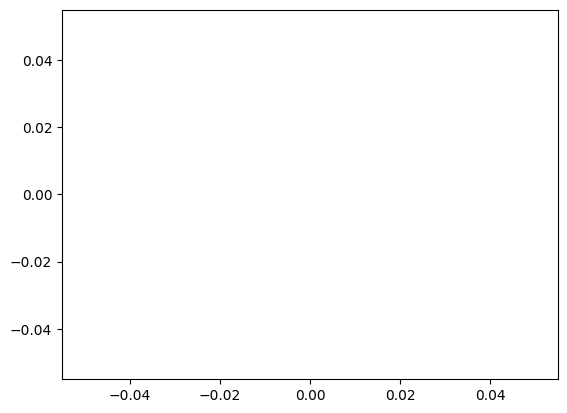

In [284]:
'''
Now, lets put it all together in the training loop.
'''

# check if gpu is available
device = 'cpu' 
if torch.backends.mps.is_available():
    device = 'mps'
if torch.cuda.is_available():
    device = 'cuda'
print(f"Using '{device}' device")

################################################################
#         TODO: YOUR CODE HERE    
#
# 1. Define the loss function, optimizer, and the BERT model. Use the model hyperparameters from the PDF.
# 2. Specify the hyperparameters for training (e.g., learning rate, batch size, etc.)
# 3. Initialize wandb for logging.
#
################################################################
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore padding tokens in the loss calculation
batch_size = 4
learning_rate = 1e-4
epochs = 250

# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

bert = BERT(vocab_size=tokenizer.get_vocab_size(), 
            hidden_size=128, 
            num_heads=4, 
            num_layers=2,
        )

optimizer = torch.optim.AdamW(bert.parameters(), lr=learning_rate)

losses = []

wandb.init(project="Homework3", name="BERT_for_MLM_test2")

# Move model and loss function to the specified device
bert.to(device)
loss_fn.to(device)

################################################################
#         TODO: YOUR CODE HERE       #
# THe training loop is where we train the model.              #
#                                                             #
# You should implement the following:                         #
# 1. Load the input_ids, attention_mask, and labels to the    #
#    device.                                                  #
# 2. Zero the gradients of the optimizer.                     #
# 3. Get the output from the BERT model.                      #
# 4. Calculate the loss using the output and the labels.      #
# 5. Backpropagate the loss.                                  #
# 6. Update the optimizer.                                    #
# 7. Log the loss to wandb.                                   #
# 8. Save the model every epoch. Use separate files per epoch #
#
# HINT: The tokenizer can be helpful here.
################################################################

# Set the model to training mode
bert.train()

for epoch in trange(epochs, desc="Epoch"):
# for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for i, (input_ids, attention_mask, labels) in enumerate(tqdm(dataloader, position=1, leave=True, desc="Step")):
        # try:
        # Move input data to the device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # print(f"Input ids shape: {input_ids.shape}")
        # print(f"Labels shape: {labels.shape}")
        
        # Forward pass
        outputs, attn = bert(input_ids, attention_mask)  

        # print(f"Output: {outputs.shape}")
        # print(f"Output shape: {outputs.view(-1, outputs.size(-1)).shape}")
        # print(f"labels shape: {labels.view(-1).shape}")

        B, T, V = outputs.shape
        outputs = outputs.view(B * T, V)
        labels = labels.view(B * T)

        # print(f"output: {outputs.shape}")
        # print(f"labels; {labels.shape}")
        
        # Calculate the loss
        # loss = loss_fn(outputs.view(-1, outputs.size(-1)), labels.view(-1))
        loss = loss_fn(outputs, labels)
        
        # Backpropagation
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Log the loss
        epoch_loss += loss.item()
        num_batches += 1

        # break

        # if (i + 1) % 100 == 0:
        wandb.log({"Loss": loss.item()}, step=epoch * len(dataloader) + i)

        # except Exception as e:
        #     print(f"Exception occurred: {e}")
        #     raise
        
    # Calculate average epoch loss
    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Avg. Loss: {avg_epoch_loss}")

    # Save the model (optional)
torch.save(bert.state_dict(), f"bert_epoch_{epoch + 1}.pt")


plt.plot(losses)


f

In [ ]:
'''
Now that we have trained the model, we can use it to predict the masked tokens.
'''

# Predict the masked tokens
def noise_inputs(inputs, mask_token_id, mlm_probability=0.15):
    inputs = deepcopy(inputs)
    labels = [-100] * len(inputs)
    masked_indices = np.random.choice(len(inputs), int(len(inputs) * mlm_probability), replace=False)
    for i in masked_indices:
        if inputs[i] not in [mask_token_id, 101, 102, 0]:
            inputs[i] = mask_token_id
            labels[i] = inputs[i]
    return inputs, labels

def noise_and_predict_tokens(query, tokenizer, model) -> str:
    with torch.no_grad():
        tokenized_input = tokenizer.encode(query)        
        tokens = tokenized_input.tokens
        print('Original:', ' '.join(tokens))
        ids = np.array(tokenized_input.ids)
        inputs, labels = noise_inputs(ids, tokenizer.token_to_id('[MASK]'))
        print('Noised: ', ' '.join([tokenizer.id_to_token(at_i) for at_i in inputs]))
        
        response, attns = model(torch.from_numpy(inputs).to(device))
        response = response.argmax(-1).squeeze(0).tolist()
        print('Guess:  ', ' '.join([tokenizer.id_to_token(at_i) for at_i in response[1:-1]]).replace(' ##', ''))

s = 'I really like the book it was great and I loved reading it.'
noise_and_predict_tokens(s, tokenizer, bert)

Original: [CLS] i really like the book it was great and i loved reading it . [SEP]
Noised:  [CLS] i really like the book it was great [MASK] i loved reading it . [SEP]


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

# Part 3.4: Save the Pre-Trained Model

At this point, save the model's parameters in its `state_dict`. See pytorch's [documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for some guidance here. We'll be using this pre-trained model in later notebooks so once you save it, test that you can load it in another notebook (try `BERT_Inference.ipynb` to start) before moving on. 

In [23]:
################################################################
#                     TODO: YOUR CODE HERE                     #
#
# 1. Save the BERT model to a file
#
# NOTE: Before you close this notebook, verify you can load the model and 
#       use it to predict the masked tokens in the BERT_Inference notebook.
#
################################################################

model = BERT(vocab_size=tokenizer.get_vocab_size(), 
            hidden_size=128, 
            num_heads=4, 
            num_layers=2,
        )

model_path = "bert_epoch_1.pt"

# Load the saved model state dictionary
state_dict = torch.load(model_path)

# Load the state dictionary into your BERT model
model.load_state_dict(state_dict)

<All keys matched successfully>

# Part 3.5 Convert the notebook to a script and submit to Great Lakes for final training

Once you have your model debugged and can verify that it works on a small dataset (manual exploration in Part 4 will help), it's time to train it on more data and for a longer time period. To do this, we'll use the Great Lakes cluster at U-M which will give you access to a GPU that will make training run ~10x faster; this means more epochs and more data in the same amount of time so you get a better model. The Homework PDF has documentation on how use Great Lakes if you haven't seen it. The course account is limited to 4 hours of wallclock time and 16GB of memory, which were tuned specific for this assignment.

Great Lakes supports interactive mode with Jupyter and running a script as a job. We **strongly** encourage the latter. To get a GPU, you'll need to submit a job to the cluster, which uses [SLURM for scheduling](https://arc.umich.edu/greatlakes/slurm-user-guide/). If you attempt to queue for an interactive job, you will have no control over when it starts, so you may end up having your notebook run for 4 hours from 3am to 7am and then it ends, at which point you have to get back in the queue. If you submit a job as a script (i.e., a .py file that runs the code in this notebook), it will run for the specified amount of time and save the BERT model without you having to interact with anything. 

SLURM and cluster scheduling is very common in some industries where there is a single cluster resource and people share it by submitting jobs to run so that no one can monopolize the system and that jobs can run in parallel. Given that Great Lakes will be useful to you in future assignments and projects, we strongly encourage you to learn how to use it effectively in this assignment.

Depending on how you're working on this file, there's a few ways to directly convert the notebook to a file if you use [Jupyter or the command line](https://mljar.com/blog/convert-jupyter-notebook-python/) or [VSCode](https://stackoverflow.com/questions/64297272/best-way-to-convert-ipynb-to-py-in-vscode). Once you convert it, you'll modify the file some to change the epochs and text file as specified in the PDF. **We also strongly recommend having your script save the model at the end of every epoch.**  That way, if your script takes longer than 4 hours and gets killed, you still have the best saved model you could get based on the amount of training you could do.